<a href="https://colab.research.google.com/github/varungowda02/Time-Series-Demand-Forecasting-ChatBot/blob/main/Time_Series_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Demand Forecasting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas -- quiet
!pip install numpy --quiet
!pip install statsmodels --quiet
!pip install matplotlib --quiet

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels as sms
import warnings
import itertools

In [5]:
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 8

Sales Data Sample (https://www.kaggle.com/datasets/kyanyoga/sample-sales-data)

About Dataset
Sample Sales Data, Order Info, Sales, Customer, Shipping, etc., Used for Segmentation, Customer Analytics, Clustering and More. Inspired for retail analytics. This was originally used for Pentaho DI Kettle, But I found the set could be useful for Sales Simulation training.

Originally Written by María Carina Roldán, Pentaho Community Member, BI consultant (Assert Solutions), Argentina. This work is licensed under the Creative Commons Attribution-Noncommercial-Share Alike 3.0 Unported License. Modified by Gus Segura June 2014.

In [9]:
sales = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/Project/sales_data_sample_utf8.csv')
sales = sales.drop_duplicates()
sales.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [10]:
sales_clean = sales.copy()
sales_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [11]:
sales_clean['ORDERDATE'] = pd.to_datetime(sales_clean['ORDERDATE'])

In [13]:
sales_clean['date'] = sales_clean['ORDERDATE'].dt.strftime("%Y-%m-%d")
sales_clean['date'] = pd.to_datetime(sales_clean['date'])

In [16]:
sales_clean['month'] = sales_clean.date.dt.month
sales_clean['year'] = sales_clean.date.dt.year
sales_clean['week'] = sales_clean.date.dt.isocalendar().week

In [19]:
sales_clean.PRODUCTLINE.unique()
sales_clean['motorcycles_QUANTITYORDERED'] = sales_clean.loc[sales_clean['PRODUCTLINE'] == 'Motorcycles', 'QUANTITYORDERED']

In [20]:
time_series = sales_clean.groupby(['week', 'month', 'year']).agg(date = ('date', 'first'), motorcycles_total_qty_ordered = ('motorcycles_QUANTITYORDERED', np.sum)).reset_index().sort_values('date')

/tmp/ipython-input-423504334.py:1: FutureWarning: The provided callable <function sum at 0x7c890cf50b80> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  time_series = sales_clean.groupby(['week', 'month', 'year']).agg(date = ('date', 'first'), motorcycles_total_qty_ordered = ('motorcycles_QUANTITYORDERED', np.sum)).reset_index().sort_values('date')


In [21]:
time_series.info()
time_series['date'] = pd.to_datetime(time_series['date'])
time_series = time_series.set_index('date')

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 2 to 63
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   week                           121 non-null    UInt32        
 1   month                          121 non-null    int32         
 2   year                           121 non-null    int32         
 3   date                           121 non-null    datetime64[ns]
 4   motorcycles_total_qty_ordered  121 non-null    float64       
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(2)
memory usage: 4.4 KB


/tmp/ipython-input-2793829088.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_series = time_series.motorcycles_total_qty_ordered.resample('M').sum()


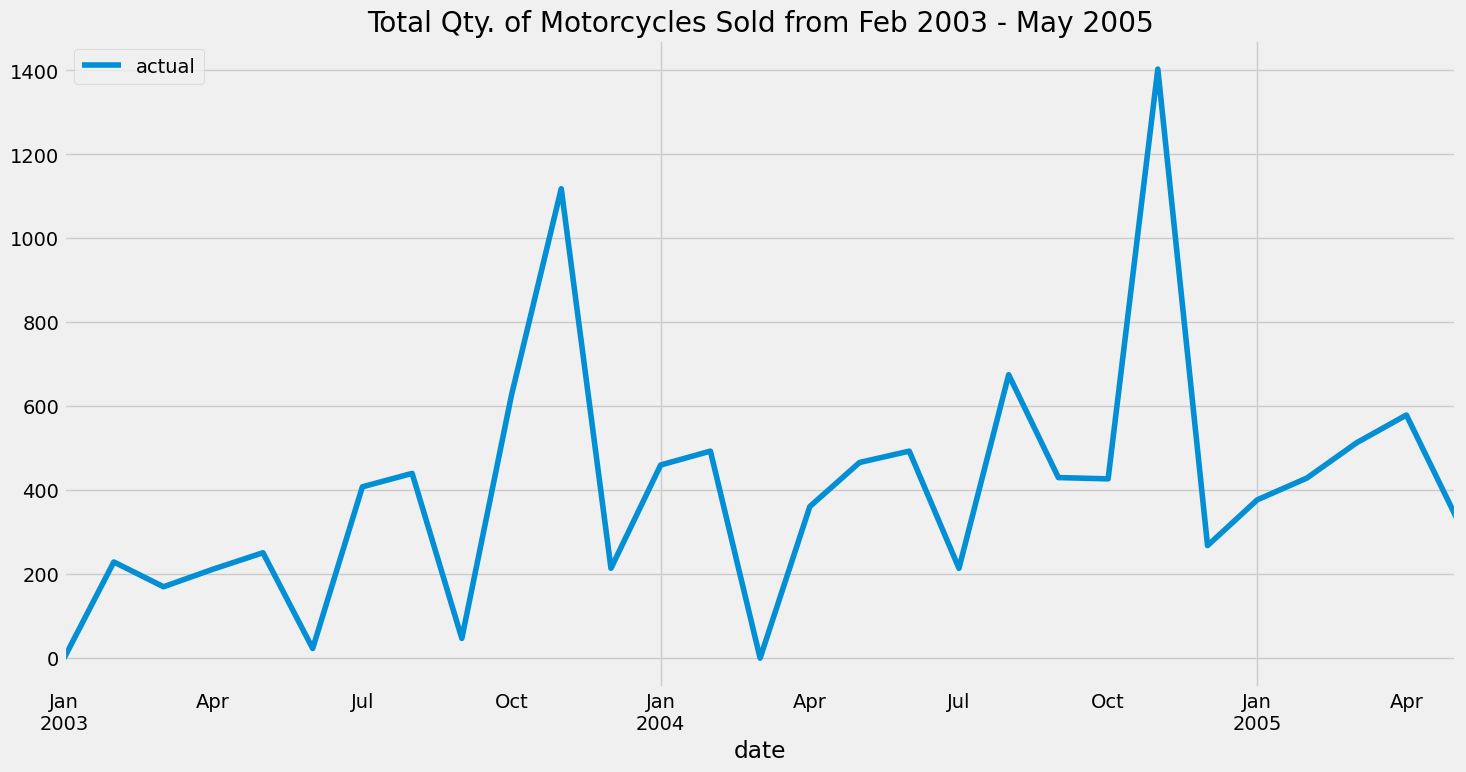

In [22]:
monthly_series = time_series.motorcycles_total_qty_ordered.resample('M').sum()

monthly_series.plot(label = 'actual').set(title = 'Total Qty. of Motorcycles Sold from Feb 2003 - May 2005')
plt.legend(loc = 'upper left')

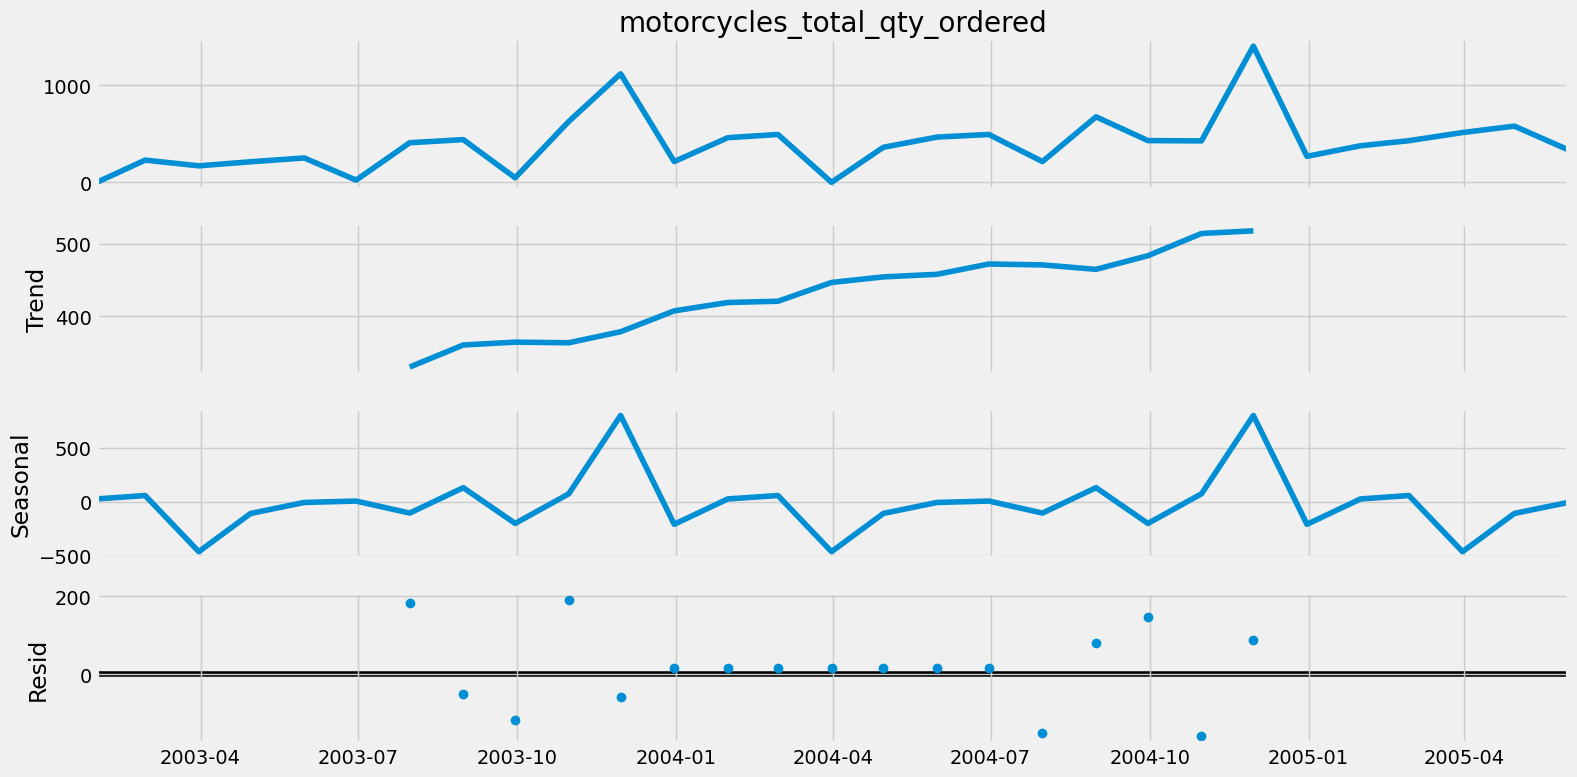

In [23]:
components = sm.tsa.seasonal_decompose(monthly_series)
components.plot()

seasonality = components.seasonal
trend = components.trend
remainder = components.resid

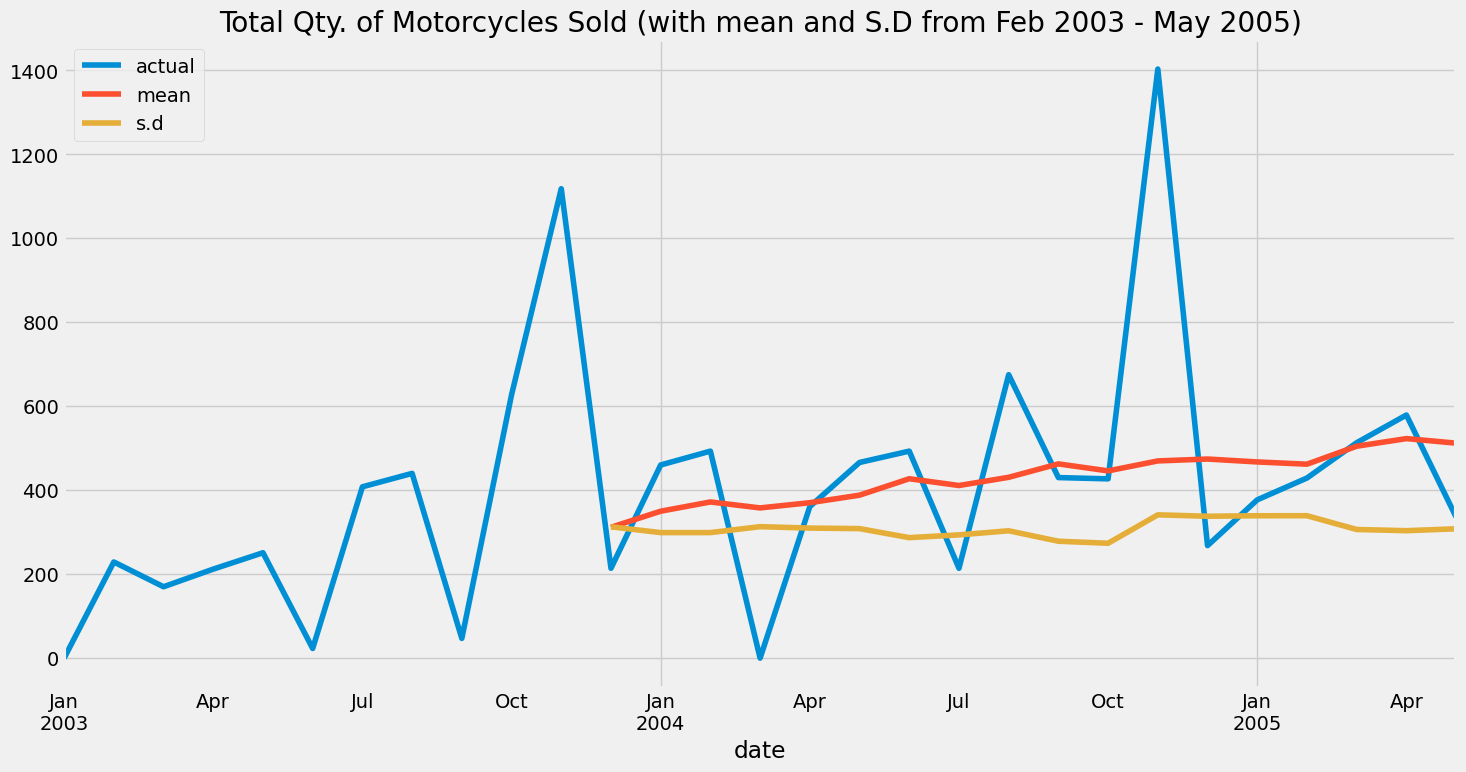

In [24]:
monthly_series.plot(label = 'actual').set(title = 'Total Qty. of Motorcycles Sold (with mean and S.D from Feb 2003 - May 2005)')
monthly_series.rolling(window = 12).mean().plot(label = 'mean')
monthly_series.rolling(window = 12).std().plot(label = 's.d')
plt.legend(loc = 'upper left')

In [25]:
ad_fuller_test = sm.tsa.stattools.adfuller(monthly_series, autolag = 'AIC')
ad_fuller_test

(np.float64(-5.288507280032339),
 np.float64(5.783924007925491e-06),
 0,
 28,
 {'1%': np.float64(-3.6889256286443146),
  '5%': np.float64(-2.9719894897959187),
  '10%': np.float64(-2.6252957653061224)},
 np.float64(274.8003625163909))

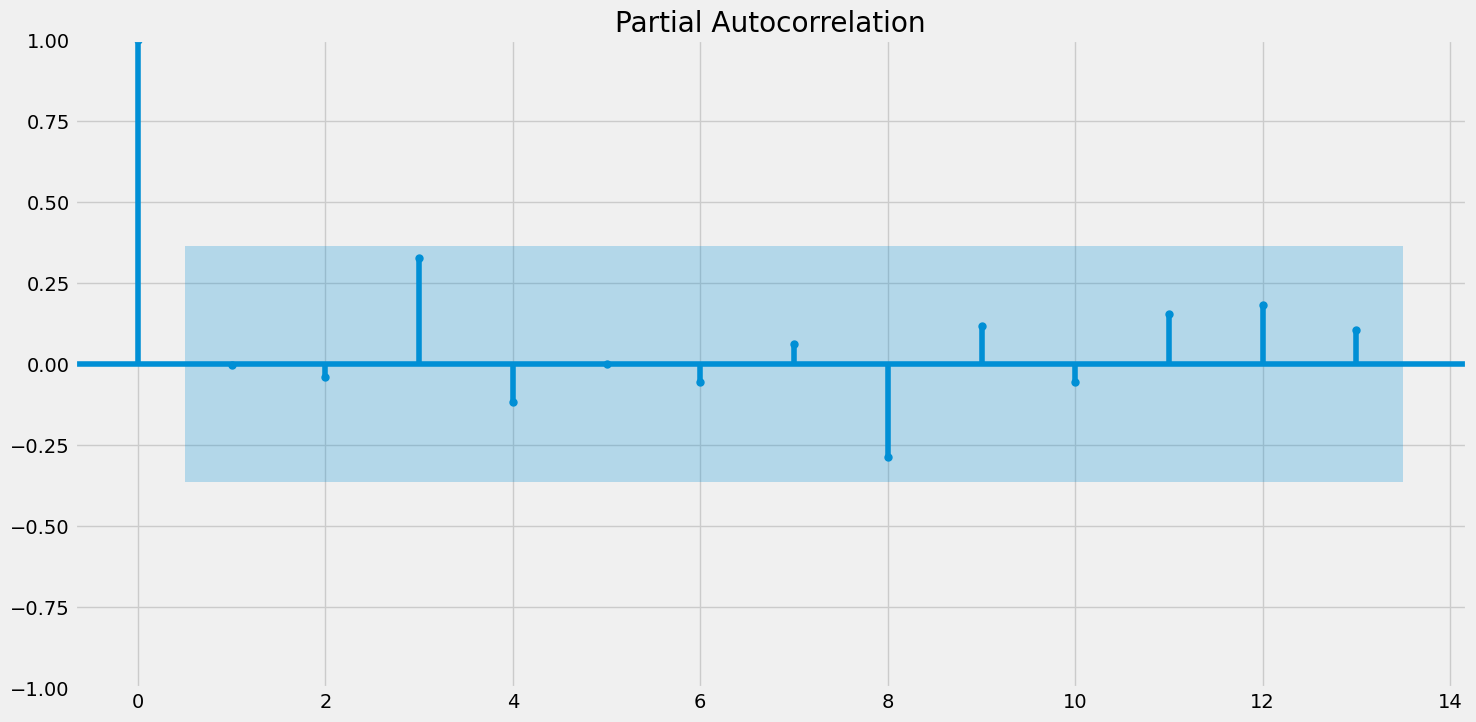

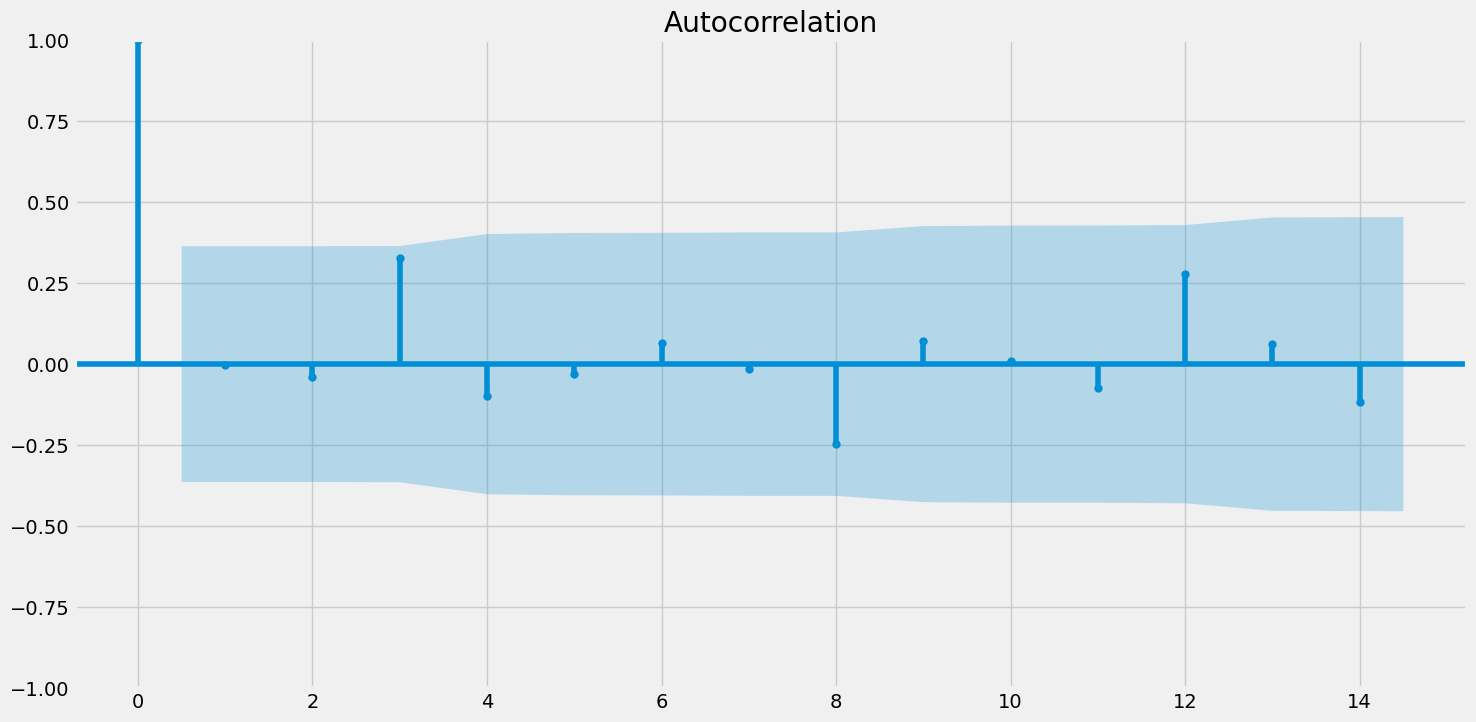

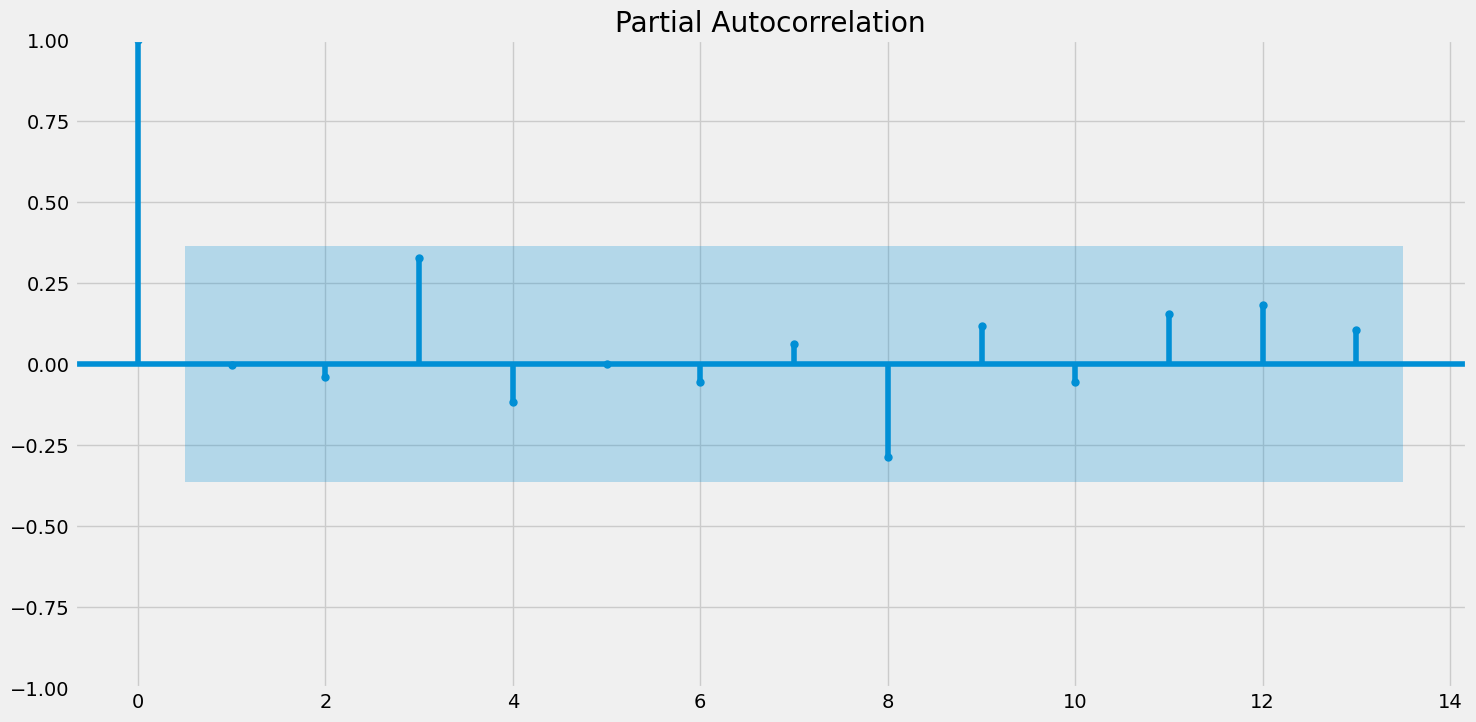

In [26]:
plot_acf(monthly_series)
plot_pacf(monthly_series, lags = 13)

In [27]:
model_MA = sm.tsa.statespace.SARIMAX(monthly_series, order = (0, 0, 1))
model_AR = sm.tsa.statespace.SARIMAX(monthly_series, order = (1, 0, 0))
model_ARMA = sm.tsa.statespace.SARIMAX(monthly_series, order = (1, 0, 1))
model_ARIMA = sm.tsa.statespace.SARIMAX(monthly_series, order = (1, 1, 1))

In [28]:
result_MA = model_MA.fit()
result_AR = model_AR.fit()
result_ARMA = model_ARMA.fit()
result_ARIMA = model_ARIMA.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [29]:
result_MA.aic
result_AR.aic
result_ARMA.aic
result_ARIMA.aic

np.float64(406.90854284006195)

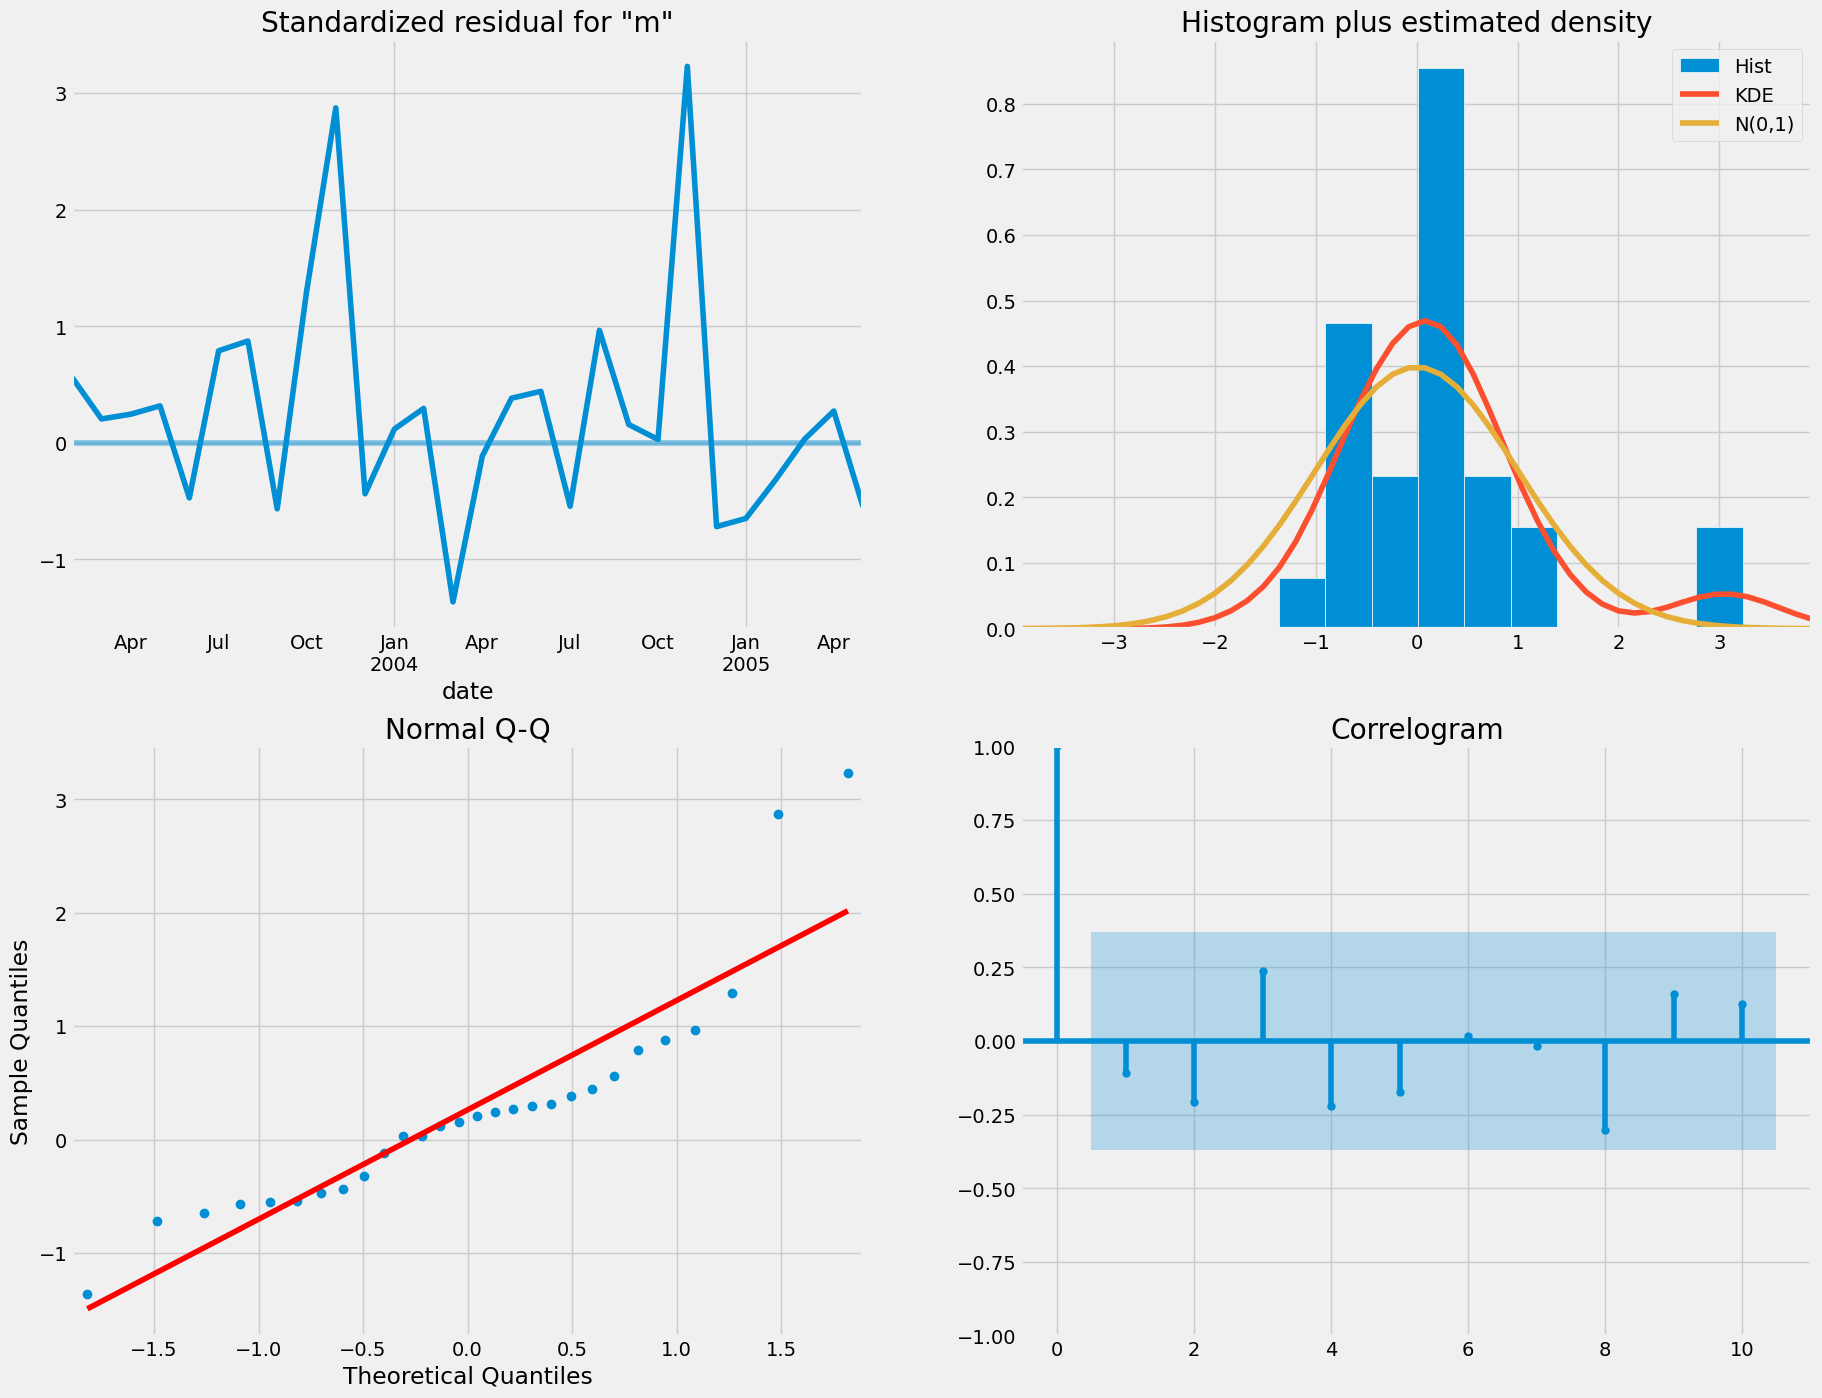

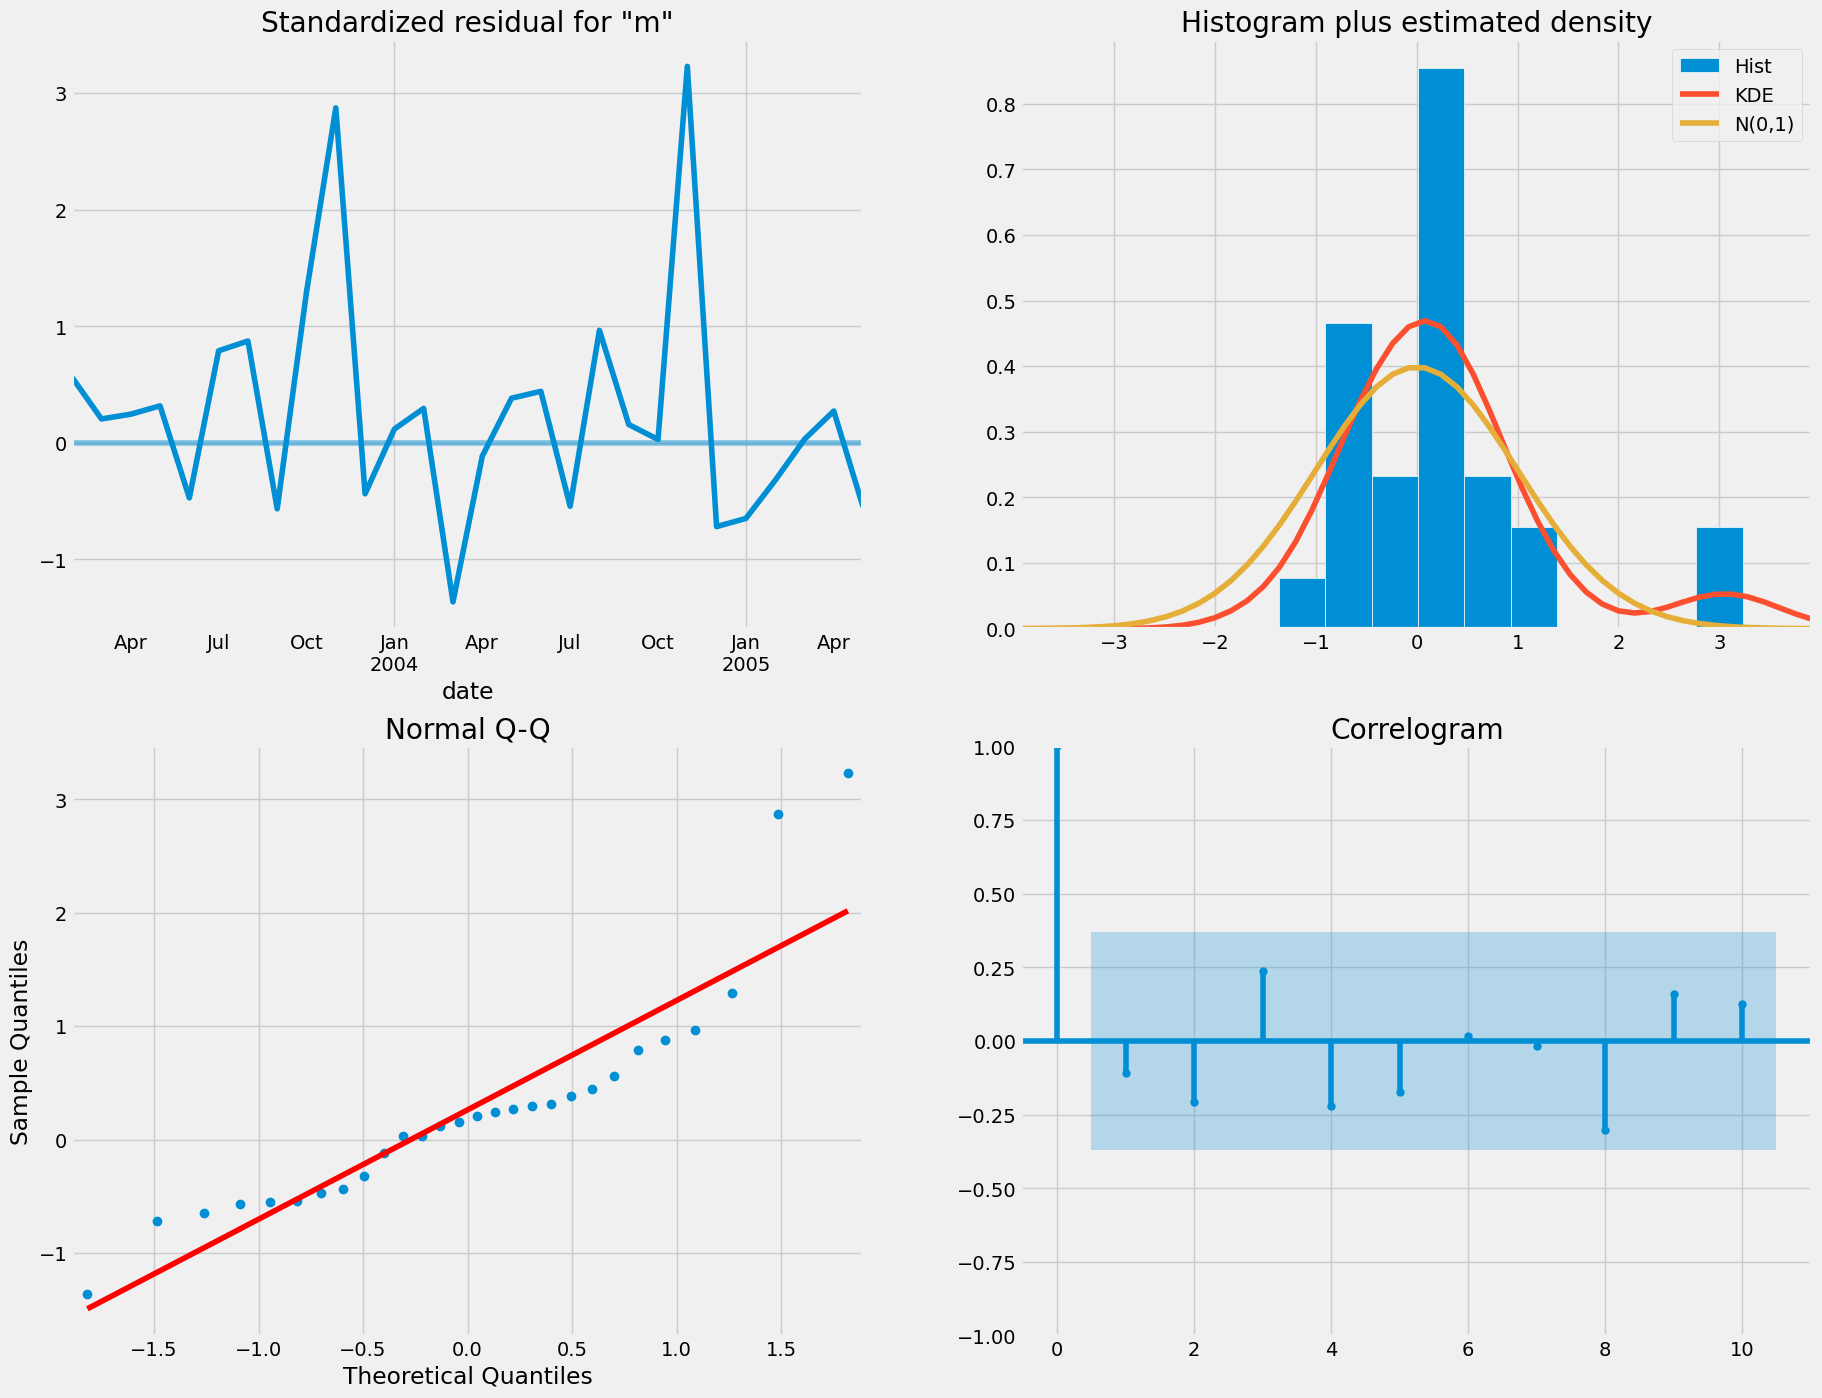

In [30]:
result_ARIMA.plot_diagnostics(figsize = [20, 16])

In [31]:
p = d = q = P = D = Q = range(0, 3)
S = 12

In [32]:
combinations = list(itertools.product(p, d, q, P, D, Q))
len(combinations)

729

In [33]:
arima_orders = [(x[0], x[1], x[2]) for x in combinations]
seasonal_orders = [(x[3], x[4], x[5], S) for x in combinations]

In [34]:
results_data = pd.DataFrame(columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'AIC'])

In [35]:
for i in range(len(combinations)):
    try:
        model = sm.tsa.statespace.SARIMAX(monthly_series, order = arima_orders[i], seasonal_order = seasonal_orders[i])
        result= model.fit()
        results_data.loc[i,'p'] = arima_orders[i][0]
        results_data.loc[i,'d'] = arima_orders[i][1]
        results_data.loc[i,'q'] = arima_orders[i][2]
        results_data.loc[i,'P'] = seasonal_orders[i][0]
        results_data.loc[i,'D'] = seasonal_orders[i][1]
        results_data.loc[i,'Q'] = seasonal_orders[i][2]
        results_data.loc[i,'AIC'] = result.aic
    except:
        continue

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimat

In [36]:
results_data[results_data.AIC == min(results_data.AIC)]

,p,d,q,P,D,Q,AIC
573,2,1,0,0,2,0,6.0


In [37]:
best_model = sm.tsa.statespace.SARIMAX(monthly_series, order = (2, 1, 0), seasonal_order = (0, 2, 0, 12))
results = best_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
monthly_series
fitting = results.get_prediction(start = '2003-01-31')
fitting_mean = fitting.predicted_mean

In [39]:
forecast = results.get_forecast(steps = 12)
forecast_mean = forecast.predicted_mean

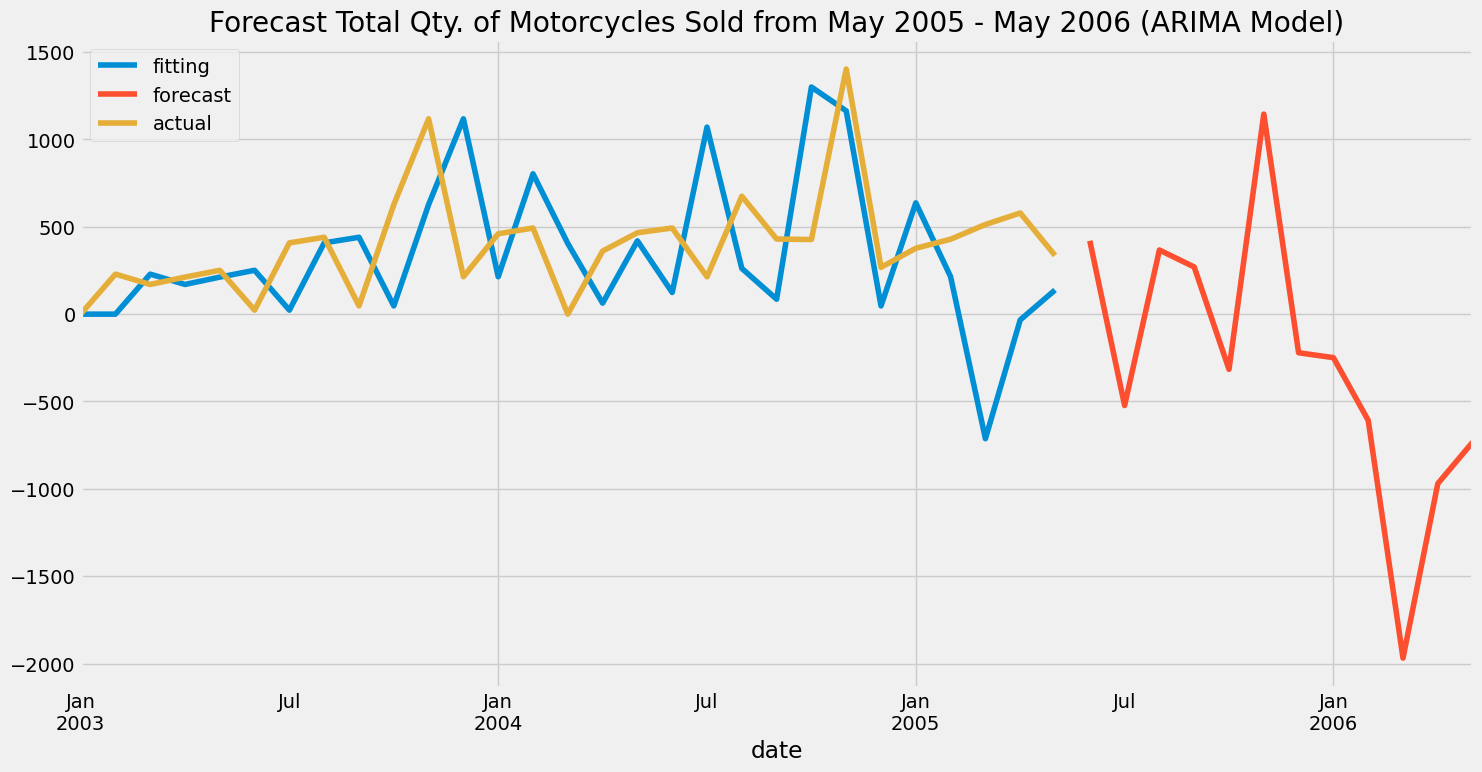

In [40]:
fitting_mean.plot(label = 'fitting').set(title = 'Forecast Total Qty. of Motorcycles Sold from May 2005 - May 2006 (ARIMA Model)')
forecast_mean.plot(label = 'forecast')
monthly_series.plot(label = 'actual')
plt.legend(loc = 'upper left')

In [41]:
mean_absolute_error = abs(monthly_series - fitting_mean).mean()

In [56]:
# # Ensure all values > 0
# if (monthly_series <= 0).any():
#     monthly_series = monthly_series + abs(monthly_series.min()) + 1

# # Now multiplicative models will work
# model_expo2 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend='mul', seasonal='add', seasonal_periods=12)
# model_expo3 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend='add', seasonal='mul', seasonal_periods=12)
# model_expo4 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend='mul', seasonal='mul', seasonal_periods=12)
model_expo1 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend = 'add', seasonal = 'add', seasonal_periods = 12)
model_expo2 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend = 'mul', seasonal = 'add', seasonal_periods = 12)
model_expo3 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend = 'add', seasonal = 'mul', seasonal_periods = 12)
model_expo4 = sms.tsa.holtwinters.ExponentialSmoothing(monthly_series, trend = 'mul', seasonal = 'mul', seasonal_periods = 12)

In [57]:
results_1 = model_expo1.fit()
results_2 = model_expo2.fit()
results_3 = model_expo3.fit()
results_4 = model_expo4.fit()

fit1 = model_expo1.fit().predict(0, len(monthly_series))
fit2 = model_expo2.fit().predict(0, len(monthly_series))
fit3 = model_expo3.fit().predict(0, len(monthly_series))
fit4 = model_expo4.fit().predict(0, len(monthly_series))

In [58]:
mae1 = abs(monthly_series - fit1).mean()
mae2 = abs(monthly_series - fit2).mean()
mae3 = abs(monthly_series - fit3).mean()
mae4 = abs(monthly_series - fit4).mean()

In [59]:
forecast = model_expo1.fit().predict(0, len(monthly_series) + 12)

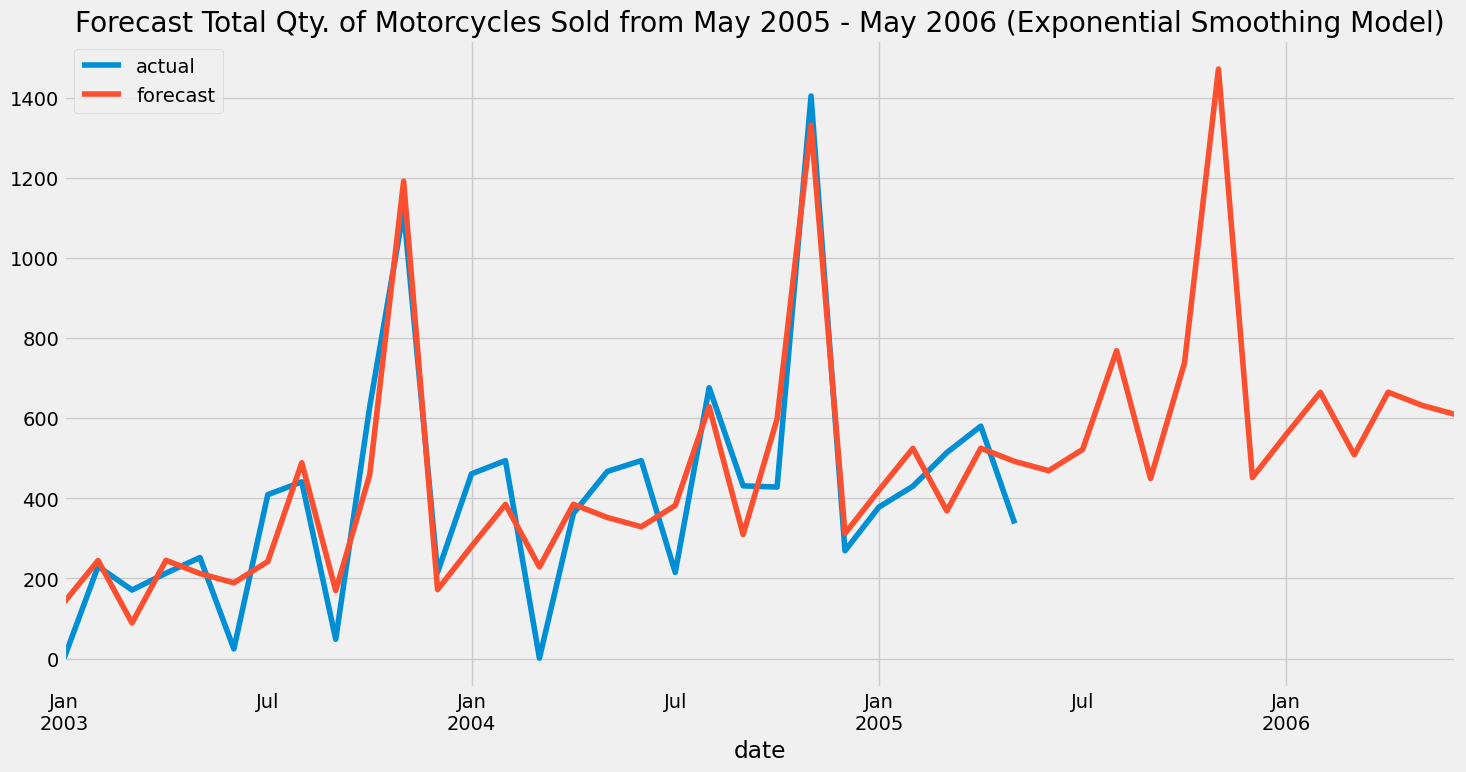

In [60]:
monthly_series.plot(label = 'actual').set(title = 'Forecast Total Qty. of Motorcycles Sold from May 2005 - May 2006 (Exponential Smoothing Model)')
forecast.plot(label = 'forecast')
plt.legend(loc = 'upper left')

In [55]:
! pip install streamlit --quiet
! pip install statsmodels --quiet
! pip install pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.6 MB/s eta 0:00:00


In [61]:
# Step 1: Install dependencies
!npm install -g localtunnel
!pip install streamlit statsmodels matplotlib

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹
added 22 packages in 3s
⠹
⠹3 packages are looking for funding
⠹  run `npm fund` for details
⠹Requirement already satisfied: streamlit in /usr/local/lib/python3.12/dist-packages (1.49.1)


In [77]:
# Step 2: Save your app as app.py
app_code = """
import streamlit as st
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels as sms
import matplotlib.pyplot as plt

#------------------------------------------
# LOAD & PREPARE DATA
#------------------------------------------
@st.cache_data
def load_data():
    url = "https://raw.githubusercontent.com/dwoo-work/time-series-demand-forecasting/main/src/sales_data_sample_utf8.csv"
    sales = pd.read_csv(url)
    sales = sales.drop_duplicates()

    sales['ORDERDATE'] = pd.to_datetime(sales['ORDERDATE'])
    sales['date'] = pd.to_datetime(sales['ORDERDATE'].dt.strftime("%Y-%m-%d"))
    sales['week'] = sales.date.dt.isocalendar().week
    sales['month'] = sales.date.dt.month
    sales['year'] = sales.date.dt.year

    sales['motorcycles_QUANTITYORDERED'] = sales.loc[sales['PRODUCTLINE'] == 'Motorcycles', 'QUANTITYORDERED']
    time_series = sales.groupby(['week','month','year']).agg(
        date=('date','first'),
        motorcycles_total_qty_ordered=('motorcycles_QUANTITYORDERED', np.sum)
    ).reset_index().sort_values('date')

    time_series['date'] = pd.to_datetime(time_series['date'])
    time_series = time_series.set_index('date')

    monthly_series = time_series.motorcycles_total_qty_ordered.resample('M').sum()
    return monthly_series

monthly_series = load_data()

#------------------------------------------
# BUILD FORECAST MODELS
#------------------------------------------
def forecast_arima(series, steps=12):
    model = sm.tsa.statespace.SARIMAX(series, order=(2,1,0), seasonal_order=(0,2,0,12))
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=steps)
    return results, forecast

def forecast_expo(series, steps=12):
    model = sms.tsa.holtwinters.ExponentialSmoothing(
        series, trend="add", seasonal="add", seasonal_periods=12
    )
    results = model.fit()
    forecast = results.forecast(steps)
    return results, forecast

#------------------------------------------
# STREAMLIT CHATBOT
#------------------------------------------
st.set_page_config(page_title="Demand Forecasting Chatbot", layout="centered")

st.title("📈 Demand Forecasting Chatbot")
st.write("Ask me about motorcycle demand forecasts!")

# Session state for conversation
if "messages" not in st.session_state:
    st.session_state["messages"] = []

# Chat input
if prompt := st.chat_input("Ask something like: Forecast next 12 months"):
    st.session_state["messages"].append({"role": "user", "content": prompt})

# Process messages
for msg in st.session_state["messages"]:
    with st.chat_message(msg["role"]):
        st.markdown(msg["content"])

# Handle last user query
if st.session_state["messages"] and st.session_state["messages"][-1]["role"] == "user":
    query = st.session_state["messages"][-1]["content"].lower()

    if "arima" in query:
        with st.chat_message("assistant"):
            st.write("Running ARIMA forecast for next 12 months...")
            results, forecast = forecast_arima(monthly_series, steps=12)

            fig, ax = plt.subplots(figsize=(10,4))
            monthly_series.plot(ax=ax, label="Actual")
            forecast.predicted_mean.plot(ax=ax, label="Forecast")
            ax.legend()
            st.pyplot(fig)

            # Show forecasted values
            st.write("### 📊 Predicted Values (ARIMA)")
            forecast_df = forecast.predicted_mean.reset_index().rename(
                columns={"index":"Date", "predicted_mean":"Forecasted_Demand"}
            )
            st.dataframe(forecast_df)

            # Download button
            csv = forecast_df.to_csv(index=False).encode("utf-8")
            st.download_button("⬇️ Download Forecast (CSV)", csv, "arima_forecast.csv", "text/csv")

    elif "expo" in query or "exponential" in query:
        with st.chat_message("assistant"):
            st.write("Running Exponential Smoothing forecast for next 12 months...")
            results, forecast = forecast_expo(monthly_series, steps=12)

            fig, ax = plt.subplots(figsize=(10,4))
            monthly_series.plot(ax=ax, label="Actual")
            forecast.plot(ax=ax, label="Forecast")
            ax.legend()
            st.pyplot(fig)

            # Show forecasted values
            st.write("### 📊 Predicted Values (Exponential Smoothing)")
            forecast_df = forecast.reset_index().rename(
                columns={"index":"Date", 0:"Forecasted_Demand"}
            )
            st.dataframe(forecast_df)

            # Download button
            csv = forecast_df.to_csv(index=False).encode("utf-8")
            st.download_button("⬇️ Download Forecast (CSV)", csv, "expo_forecast.csv", "text/csv")

    elif "forecast" in query:
        with st.chat_message("assistant"):
            st.write("I can use ARIMA or Exponential Smoothing. Please type:")
            st.write("- `forecast using arima`")
            st.write("- `forecast using expo`")

    else:
        with st.chat_message("assistant"):
            st.write("Sorry, I didn't understand. Try asking: *Forecast using ARIMA* or *Forecast using Expo*")

"""

with open("app.py", "w") as f:
    f.write(app_code)


In [78]:
!pip install pyngrok  # optional
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

# Run streamlit in background
import subprocess, threading

def run_streamlit():
    subprocess.call(["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0"])

threading.Thread(target=run_streamlit).start()

# Expose via cloudflared
!cloudflared tunnel --url http://localhost:8501

--2025-09-02 11:13:35--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.8.1/cloudflared-linux-amd64.deb [following]
--2025-09-02 11:13:35--  https://github.com/cloudflare/cloudflared/releases/download/2025.8.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/92cb7978-e346-4125-ab19-54eebccb08b0?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-02T12%3A01%3A50Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64.deb&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&